## Logistic Regression

In this section we will implement a logistic regression model trainable with SGD using numpy. Here are the objectives:

1. Implement a simple forward model with no hidden layer (equivalent to logistic regression):
$y = softmax(\mathbf{W} x + b)$

1. build a `predict` function which returns the most probable class given an input $x$

1. build an `accuracy` function for a batch of inputs $X$ and the corresponding expected outputs $y_{true}$

1. build a `grad` function which computes $\frac{d}{dW} -\log(softmax(Wx + b))$ for an $x$ and its corresponding expected output $y_{true}$ ; check that the gradients are well defined

1. build a `train` function which uses the `grad` function output to update $\mathbf{W}$ and $b$


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8, 8)
plt.rcParams["font.size"] = 14

from sklearn.datasets import load_digits
import numpy as np

digits = load_digits()

First let's define a helper function to compute the one hot encoding of an integer array for a fixed number of classes:

In [2]:
def one_hot(n_classes, y):
    return np.eye(n_classes)[y]

In [3]:
one_hot(10, 3)

array([ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.])

In [4]:
one_hot(10, [3,2,1,0])

array([[ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])

In [5]:
one_hot(10, [0, 4, 9, 1])

array([[ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])

Let's take a moment to take a look at the dataset before we start using it.

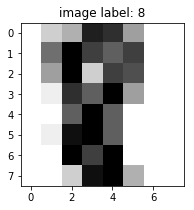

In [9]:
sample_index = 42 + 31 + 3 # change this to see different examples
plt.figure(figsize=(3, 3))
plt.imshow(digits.images[sample_index], cmap=plt.cm.gray_r,
           interpolation='nearest')
plt.title("image label: %d" % digits.target[sample_index]);

### Preprocessing

- normalization (for more take a look at http://scikit-learn.org/stable/modules/preprocessing.html)
- train/test split

In [10]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing


data = np.asarray(digits.data, dtype='float32')
target = np.asarray(digits.target, dtype='int32')

X_train, X_test, y_train, y_test = train_test_split(
    data, target, test_size=0.15, random_state=37)

scaler = preprocessing.StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Y_train = one_hot(10, y_train)
Y_test = one_hot(10, y_test)

In [11]:
Y_train = one_hot(10, y_train)
Y_train[:3]

array([[ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
       [ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.]])

Let's display the one of the transformed sample (after feature standardization):

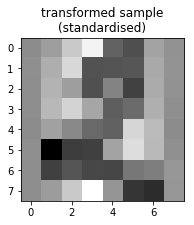

In [12]:
sample_index = 45
plt.figure(figsize=(3, 3))
plt.imshow(X_train[sample_index].reshape(8, 8),
           cmap=plt.cm.gray_r, interpolation='nearest')
plt.title("transformed sample\n(standardised)");

The scaler objects makes it possible to recover the original sample:

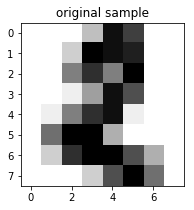

In [13]:
plt.figure(figsize=(3, 3))
plt.imshow(scaler.inverse_transform(X_train[sample_index]).reshape(8, 8),
           cmap=plt.cm.gray_r, interpolation='nearest')
plt.title("original sample");

Now let's implement the softmax vector function:

$$
softmax(\mathbf{x}) = \frac{1}{\sum_{i=1}^{n}{e^{x_i}}}
\cdot
\begin{bmatrix}
  e^{x_1}\\\\
  e^{x_2}\\\\
  \vdots\\\\
  e^{x_n}
\end{bmatrix}
$$

In [22]:
def softmax(X):
    # TODO:
    exp = np.exp(X)
    return exp / np.sum(exp, axis=-1, keepdims=True)

Make sure that this works one vector at a time (and check that the components sum to one):

In [23]:
print(softmax([10, 2, -3]))

[  9.99662391e-01   3.35349373e-04   2.25956630e-06]


Note that a naive implementation of softmax might not be able process a batch of activations in a single call (but we need that):

In [24]:
X = np.array([[10, 2, -3],
              [-1, 5, -20]])
print(softmax(X))

[[  9.99662391e-01   3.35349373e-04   2.25956630e-06]
 [  2.47262316e-03   9.97527377e-01   1.38536042e-11]]


Implement a function that given the true one-hot encoded class `Y_true` and and some predicted probabilities `Y_pred` returns the negative log likelihood.

In [27]:
EPSILON = 1e-8

def nll(Y_true, Y_pred):
    # TODO
    # Solution is in two cells time
    return None

# Make sure that it works for a simple sample at a time
print(nll([1, 0, 0], [.99, 0.01, 0]))

None


Check that the `nll` of a very confident yet incorrect prediction is a much higher positive number:

In [ ]:
print(nll([1, 0, 0], [0.01, 0.01, .98]))

Make sure that your implementation can compute the average negative log likelihood of a group of predictions: `Y_pred` and `Y_true` can therefore be passed in as 2D arrays:

In [30]:
def nll(Y_true, Y_pred):
    Y_true, Y_pred = np.atleast_2d(Y_true), np.atleast_2d(Y_pred)
    loglikelihoods = np.sum(np.log(EPSILON + Y_pred) * Y_true, axis=1)
    return -np.mean(loglikelihoods)

In [33]:
# Check that the average NLL of the following 3 almost perfect
# predictions is close to 0
Y_true = np.array([[0, 1, 0],
                   [1, 0, 0],
                   [0, 0, 1]])

Y_pred = np.array([[0,   0.99,    0],
                   [.99, 0.01, 0],
                   [0,   0,    1]])

print(nll(Y_true, Y_pred))

0.00670021383499


Finally we have all the ingredients for training a logistic regression model using gradient descent.

Let's study it **one sample at a time**.

In [34]:
class LogisticRegression():
    def __init__(self, input_size, output_size):
        self.W = np.random.uniform(size=(input_size, output_size),
                                   high=0.1, low=-0.1)
        self.b = np.random.uniform(size=output_size,
                                   high=0.1, low=-0.1)
        self.output_size = output_size
        
    def forward(self, X):
        # TODO: compute normalised scores
        Z = np.dot(X, self.W) + self.b
        return softmax(Z)
    
    def predict(self, X):
        # TODO: for each sample return the predicted class
        if len(X.shape) == 1:
            return np.argmax(self.forward(X))
        else:
            return np.argmax(self.forward(X), axis=1)
    
    def grad_loss(self, x, y_true):
        # TODO?: compute gradient with respect to W and b for a sample x
        # and the true labels y_true
        y_pred = self.forward(x)
        dnll_output =  y_pred - one_hot(self.output_size, y_true)
        grad_W = np.outer(x, dnll_output)
        grad_b = dnll_output
        grads = {"W": grad_W, "b": grad_b}
        return grads
    
    def train(self, x, y, learning_rate):
        # TODO:
        # Traditional gradient descent update without momentum
        grads = self.grad_loss(x, y)
        self.W = self.W - learning_rate * grads["W"]
        self.b = self.b - learning_rate * grads["b"]      
        
    def loss(self, x, y):
        # TODO: use `nll` to compute the loss for the sample x with true label y
        return nll(one_hot(self.output_size, y), self.forward(x))

    def accuracy(self, X, y):
        # TODO: compute accuracy for samples X with true labels y
        y_preds = np.argmax(self.forward(X), axis=1)
        return np.mean(y_preds == y)

In [35]:
one_hot(10, y_train)

array([[ 0.,  0.,  1., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  1.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  1.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  1.,  0., ...,  0.,  0.,  0.]])

In [36]:
y_train

array([2, 9, 5, ..., 9, 4, 1], dtype=int32)

In [51]:
# Build a model and test its forward inference
n_features = X_train.shape[1]
n_classes = Y_train.shape[1]
lr = LogisticRegression(n_features, n_classes)

print("Evaluation of the untrained model:")
train_loss = lr.loss(X_train, y_train)
train_acc = lr.accuracy(X_train, y_train)
test_acc = lr.accuracy(X_test, y_test)

print("train loss: %0.4f, train acc: %0.3f, test acc: %0.3f"
      % (train_loss, train_acc, test_acc))

Evaluation of the untrained model:
train loss: 2.2974, train acc: 0.191, test acc: 0.159


4


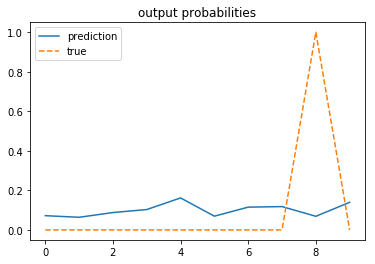

In [55]:
# Test the untrained model on the first example
sample_idx = 3 + 45
plt.plot(lr.forward(X_train[sample_idx]), linestyle='-', label='prediction')
plt.plot(one_hot(10, y_train[sample_idx]), linestyle='--', label='true')
plt.title('output probabilities')
plt.legend()
print(lr.predict(X_train[sample_idx]))

In [56]:
# Training for one epoch
learning_rate = 0.01

for i, (x, y) in enumerate(zip(X_train, y_train)):
    lr.train(x, y, learning_rate)
    if i % 100 == 0:
        train_loss = lr.loss(X_train, y_train)
        train_acc = lr.accuracy(X_train, y_train)
        test_acc = lr.accuracy(X_test, y_test)
        print("Update #%d, train loss: %0.4f, train acc: %0.3f, test acc: %0.3f"
              % (i, train_loss, train_acc, test_acc))

Update #0, train loss: 2.2673, train acc: 0.204, test acc: 0.170
Update #100, train loss: 1.3026, train acc: 0.688, test acc: 0.696
Update #200, train loss: 0.8639, train acc: 0.857, test acc: 0.878
Update #300, train loss: 0.6373, train acc: 0.897, test acc: 0.904
Update #400, train loss: 0.5303, train acc: 0.912, test acc: 0.922
Update #500, train loss: 0.4601, train acc: 0.922, test acc: 0.926
Update #600, train loss: 0.4039, train acc: 0.926, test acc: 0.930
Update #700, train loss: 0.3668, train acc: 0.936, test acc: 0.948
Update #800, train loss: 0.3441, train acc: 0.940, test acc: 0.952
Update #900, train loss: 0.3192, train acc: 0.941, test acc: 0.948
Update #1000, train loss: 0.2984, train acc: 0.948, test acc: 0.959
Update #1100, train loss: 0.2807, train acc: 0.948, test acc: 0.959
Update #1200, train loss: 0.2691, train acc: 0.950, test acc: 0.963
Update #1300, train loss: 0.2588, train acc: 0.952, test acc: 0.952
Update #1400, train loss: 0.2458, train acc: 0.956, test acc

7
7


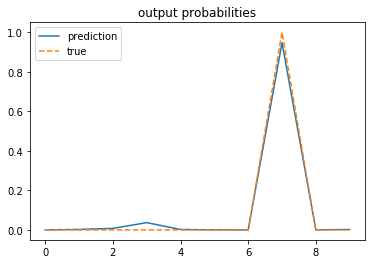

In [59]:
# Evaluate the trained model on an example
sample_idx = 899 -234
plt.plot(lr.forward(X_train[sample_idx]), linestyle='-', label='prediction')
plt.plot(one_hot(10, y_train[sample_idx]), linestyle='--', label='true')
plt.title('output probabilities')
plt.legend()
print(lr.predict(X_train[sample_idx]))
print(y_train[sample_idx])

Questions:

* can you find examples that are mispredicted, is there a pattern to the wrong predictions?
* visualise the samples and predicted classes
* plot the [confusion matrix](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) to classes that are hard to separate (maybe eight vs nine?)

predicted 3
true label: 8


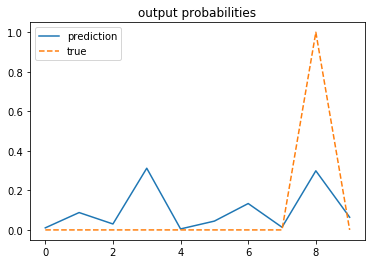

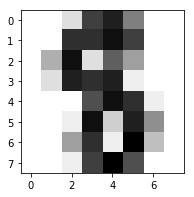

In [67]:
# Evaluate the trained model on an example
for sample_idx in range(150):
    if lr.predict(X_test[sample_idx]) != y_test[sample_idx]:
        plt.plot(lr.forward(X_test[sample_idx]), linestyle='-', label='prediction')
        plt.plot(one_hot(10, y_test[sample_idx]), linestyle='--', label='true')
        plt.title('output probabilities')
        plt.legend()
        print('predicted', lr.predict(X_test[sample_idx]))
        print('true label:',y_test[sample_idx])

        plt.figure(figsize=(3, 3))
        plt.imshow(scaler.inverse_transform(X_test[sample_idx]).reshape(8, 8),
                   cmap=plt.cm.gray_r, interpolation='nearest')
        break